In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
%matplotlib inline

from nanonets.utils import load_boolean_results, fitness, abundance, nonlinear_parameter, return_ndr, return_nls
from scipy.optimize import curve_fit

# data_folderA = "/home/jonasmensing/bagheera/data/1_funding_period/controls/posA/"
# data_folderB = "/home/jonasmensing/bagheera/data/1_funding_period/controls/posB/"
data_folderA = "/home/j/j_mens07/bagheera/data/1_funding_period/controls/posA/"
data_folderB = "/home/j/j_mens07/bagheera/data/1_funding_period/controls/posB/"
GATES        = ["AND","OR","XOR","NAND","NOR","XNOR"]

In [4]:
# Parameter
N_valsA = [4,6,8,10,12,14,16]
N_keysA = len(N_valsA)
N_valsB = [4,6,8,10,12,14,16]
N_keysB = len(N_valsB)
N_np    = 9

# Boolean On and Off
off_statesA = np.array(N_keysA*[0.0])
off_statesB = np.array(N_keysB*[0.0])
on_statesA  = np.array(N_keysA*[0.01])
on_statesB  = np.array(N_keysB*[0.01])

dataA = load_boolean_results(folder=data_folderA, N=N_np, N_e=N_valsA, input_cols=['E0','E1'], on_state=0.01, max_error=0.1)
dataB = load_boolean_results(folder=data_folderB, N=N_np, N_e=N_valsB, input_cols=['E0','E1'], on_state=0.01, max_error=0.1)

## Fitness Abundance

In [5]:
delta       = 0.0
fitnessA    = {N : fitness(df=dataA[N], input_cols=['E0','E1'], delta=delta) for N in N_valsA}
abundanceA  = {N : abundance(df=fitnessA[N]) for N in N_valsA}

fitnessB    = {N : fitness(df=dataB[N], input_cols=['E0','E1'], delta=delta) for N in N_valsB}
abundanceB  = {N : abundance(df=fitnessB[N]) for N in N_valsB}

In [7]:
fitness_res = pd.DataFrame()

for j, N in enumerate(N_valsA): 

    df          = pd.melt(fitnessA[N].loc[:,'AND Fitness':], var_name='Gate', value_name='Fitness')
    df['$N_C$'] = N-3
    df['key']   = 'Distal Inputs'
    fitness_res = pd.concat([fitness_res, df], ignore_index=True)

for j, N in enumerate(N_valsB):
    
    df          = pd.melt(fitnessB[N].loc[:,'AND Fitness':], var_name='Gate', value_name='Fitness')
    df['$N_C$'] = N-3
    df['key']   = 'Proximal Inputs'
    fitness_res = pd.concat([fitness_res, df], ignore_index=True)
fitness_res.head(10)

,Gate,Fitness,$N_C$,key
0,AND Fitness,2.664298,1,Distal Inputs
1,AND Fitness,2.938001,1,Distal Inputs
2,AND Fitness,3.116369,1,Distal Inputs
3,AND Fitness,3.055517,1,Distal Inputs
4,AND Fitness,2.624334,1,Distal Inputs
5,AND Fitness,3.123653,1,Distal Inputs
6,AND Fitness,3.207302,1,Distal Inputs
7,AND Fitness,3.430940,1,Distal Inputs
8,AND Fitness,3.043139,1,Distal Inputs
9,AND Fitness,2.860265,1,Distal Inputs


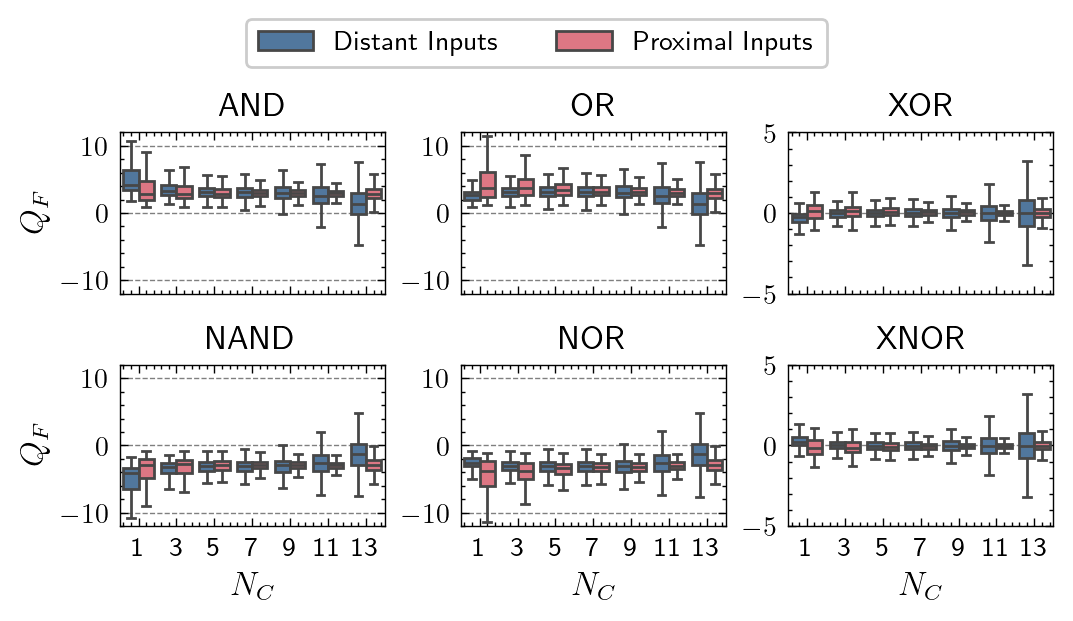

In [34]:
with plt.style.context(["science", "bright", "grid"]):
    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth() * 1.5)

    # --- CHANGE 1: Prepare variables to store legend info ---
    handles, labels = None, None

    for i, gate in enumerate(GATES):
        ax = fig.add_subplot(2, 3, i + 1)
        
        # Plot the boxplot
        sns.boxplot(
            data=fitness_res[fitness_res['Gate'] == f'{gate} Fitness'],
            x='$N_C$',
            y='Fitness',
            hue='key',
            fliersize=0,
            ax=ax,
            # Let seaborn create a legend only for the first plot
            legend=(i == 0) 
        )

        # --- CHANGE 2: Grab handles/labels from the first plot and hide its legend ---
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()

        if gate[0] == 'X':
            ax.set_ylim(-5, 5)
        else:
            ax.set_ylim(-12, 12)
        ax.set_title(gate)

        if i >= 3:
            ax.set_xlabel("$N_C$", fontsize='large')
        else:
            ax.set_xticklabels("")
            ax.set_xlabel("")

        if i % 3 == 0:
            ax.set_ylabel("$Q_F$", fontsize='large')
        else:
            ax.set_ylabel("")
            # ax.set_yticklabels("")

    labels = ['Distant Inputs', 'Proximal Inputs']
    fig.legend(handles, labels, loc='upper center', ncol=2, title='', bbox_to_anchor=(0.5,1.15))

    fig.savefig(f"plots/box_plots.svg", transparent=True)
    fig.savefig(f"plots/box_plots.pdf", transparent=True)

## Nonlinear Parameter

In [35]:
# x_vals  = [f"A{i-3}" for i in N_valsA] + [f"B{i-3}" for i in N_valsB[::-1]]

# Current Relations
n_bootstrap = 100
paramsA = {N : nonlinear_parameter(dataA[N], input1_column='E0', input2_column='E1', n_bootstrap=n_bootstrap) for i, N in enumerate(N_valsA)}
paramsB = {N : nonlinear_parameter(dataB[N], input1_column='E0', input2_column='E1', n_bootstrap=n_bootstrap) for i, N in enumerate(N_valsB)}

# NDR
Q_ndrA   = []
Q_ndrB   = []
Q_nlsA   = []
Q_nlsB   = []
for i in range(n_bootstrap):
    Q_ndr_l = np.array([return_ndr(paramsA[N][i]['Ml']) for N in N_valsA])
    Q_ndr_r = np.array([return_ndr(paramsA[N][i]['Mr']) for N in N_valsA])
    Q_ndrA.append((Q_ndr_l + Q_ndr_r) / 2)

    # NDR
    Q_ndr_l = np.array([return_ndr(paramsB[N][i]['Ml']) for N in N_valsB])
    Q_ndr_r = np.array([return_ndr(paramsB[N][i]['Mr']) for N in N_valsB])
    Q_ndrB.append((Q_ndr_l + Q_ndr_r) / 2)
    # Q_ndr   = np.append(Q_ndrA, Q_ndrB)

    # NLS
    bins    = 100
    Q_nlsA.append(np.array([return_nls(df=paramsA[N][i], bins=bins) for N in N_valsA]))
    Q_nlsB.append(np.array([return_nls(df=paramsB[N][i], bins=bins) for N in N_valsB]))
    # Q_nls   = np.append(Q_nlsA, Q_nlsB)

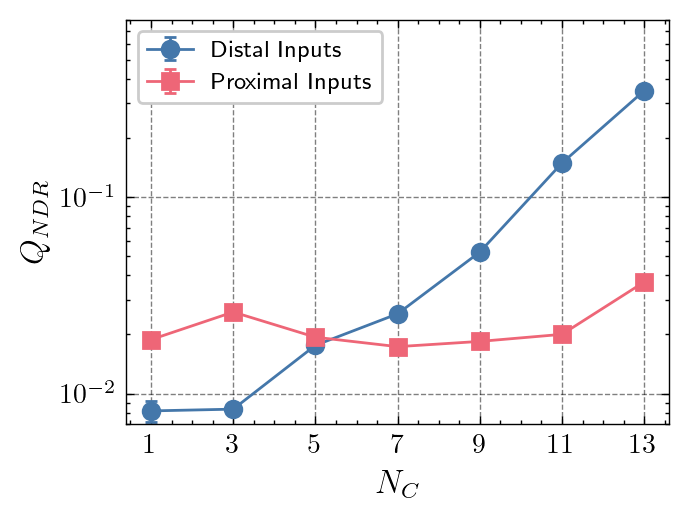

In [67]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    p = ax.errorbar(np.array(N_valsA)-3, np.mean(Q_ndrA,axis=0), 1.96*np.std(Q_ndrA,axis=0), marker='o', capsize=2, label='Distal Inputs')
    p = ax.errorbar(np.array(N_valsB)-3, np.mean(Q_ndrB,axis=0), 1.96*np.std(Q_ndrB,axis=0), marker='s', capsize=2, label='Proximal Inputs')
    ax.legend(loc='upper left', fontsize='small')
    ax.set_ylabel("$Q_{NDR}$", fontsize='large')
    ax.set_xlabel("$N_C$", fontsize='large')
    ax.set_xticks(np.array(N_valsB)-3)
    ax.set_yscale('log')
    ax.set_ylim(7e-3,8e-1)

fig.savefig("plots/q_ndr_vs_nc.svg", transparent=True)
fig.savefig("plots/q_ndr_vs_nc.pdf", transparent=True)

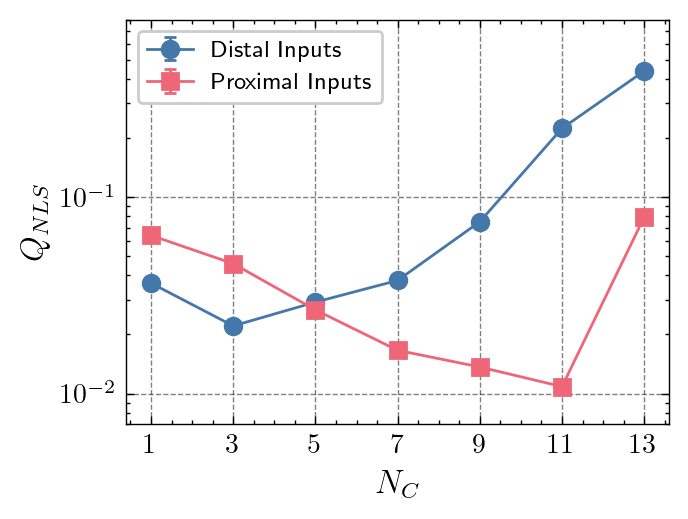

In [64]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    p = ax.errorbar(np.array(N_valsA)-3, np.mean(Q_nlsA,axis=0), 1.96*np.std(Q_nlsA,axis=0), marker='o', capsize=2, label='Distal Inputs')
    p = ax.errorbar(np.array(N_valsB)-3, np.mean(Q_nlsB,axis=0), 1.96*np.std(Q_nlsB,axis=0), marker='s', capsize=2, label='Proximal Inputs')
    ax.legend(loc='upper left', fontsize='small')
    ax.set_ylabel("$Q_{NLS}$", fontsize='large')
    ax.set_xlabel("$N_C$", fontsize='large')
    ax.set_xticks(np.array(N_valsB)-3)
    ax.set_yscale('log')
    ax.set_ylim(7e-3,8e-1)

fig.savefig("plots/q_nls_vs_nc.svg", transparent=True)
fig.savefig("plots/q_nls_vs_nc.pdf", transparent=True)

In [65]:
# with plt.style.context(["science","bright","grid"]):

#     fig = plt.figure(dpi=200)
#     # fig.set_figwidth(fig.get_figwidth()*1.5)
#     # fig.set_figheight(fig.get_figheight()*0.8)
#     ax  = fig.add_subplot()
#     p = ax.plot(np.array(N_valsA)-3, Q_ndrA, '-o', label='Distal Inputs, NDR')
#     ax.plot(np.array(N_valsB)-3, Q_ndrB, '-s', label='Proximal Inputs, NDR', color=p[0].get_color())
#     ax.set_ylim(0.0,0.5)

#     p = ax.plot(np.array(N_valsA)-3, Q_nlsA, '-o', label='Distal Inputs, NLS')
#     ax.plot(np.array(N_valsB)-3, Q_nlsB, '-s', label='Proximal Inputs, NLS', color=p[0].get_color())

#     ax.legend(loc='upper left', fontsize='small')
#     ax.set_ylabel("$Q$")
#     ax.set_xlabel("$N_C$")
#     ax.set_xticks(np.array(N_valsB)-3)

#     ax.set_ylim(0.005,0.5)
#     ax.set_yscale('log')

# fig.savefig("plots/nonlinear_params_log.svg", transparent=True)

---

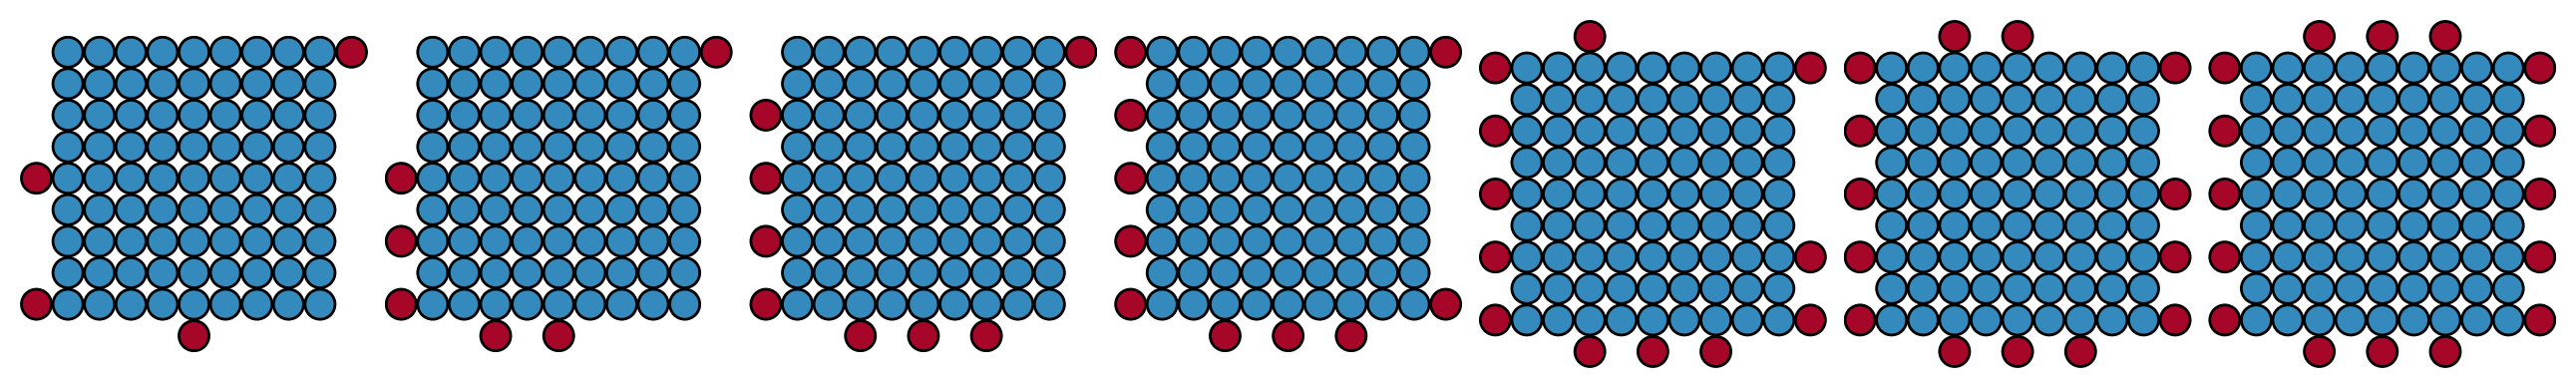

In [15]:
from nanonets import Simulation
from nanonets.utils import display_network

N_PARTICLES = 9
N_CONTROLS  = [1,3,5,7,9,11,13]

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

for i, N_c in enumerate(N_CONTROLS):
    ax   = fig.add_subplot(1,7,i+1)
    topo = {"Nx":N_PARTICLES,"Ny":N_PARTICLES}
    pos  = [[4,0],[0,4]]
    if N_c >= 1:
        pos.append([0,0])
    if N_c >= 3:
        pos.append([2,0])    
        pos.append([0,2])
    if N_c >= 5:
        pos.append([6,0])    
        pos.append([0,6])    
    if N_c >= 7:
        pos.append([8,0])    
        pos.append([0,8])    
    if N_c >= 9:
        pos.append([8,2])    
        pos.append([2,8])    
    if N_c >= 11:
        pos.append([8,4])    
        pos.append([4,8])
    if N_c >= 13:    
        pos.append([8,6])    
        pos.append([6,8])
    pos.append([8,8])
    N_e = len(pos)
    topo["e_pos"] = pos
    topo["electrode_type"] = N_e*['constant']
    sim_class = Simulation(topo, pack_optimizer=False)
    fig, ax = display_network(sim_class.get_graph(), sim_class.get_positions(), sim_class.get_radius(), fig, ax)
    ax.axis('off')
fig.savefig(f"plots/network_plots_pos_A.svg", transparent=True)

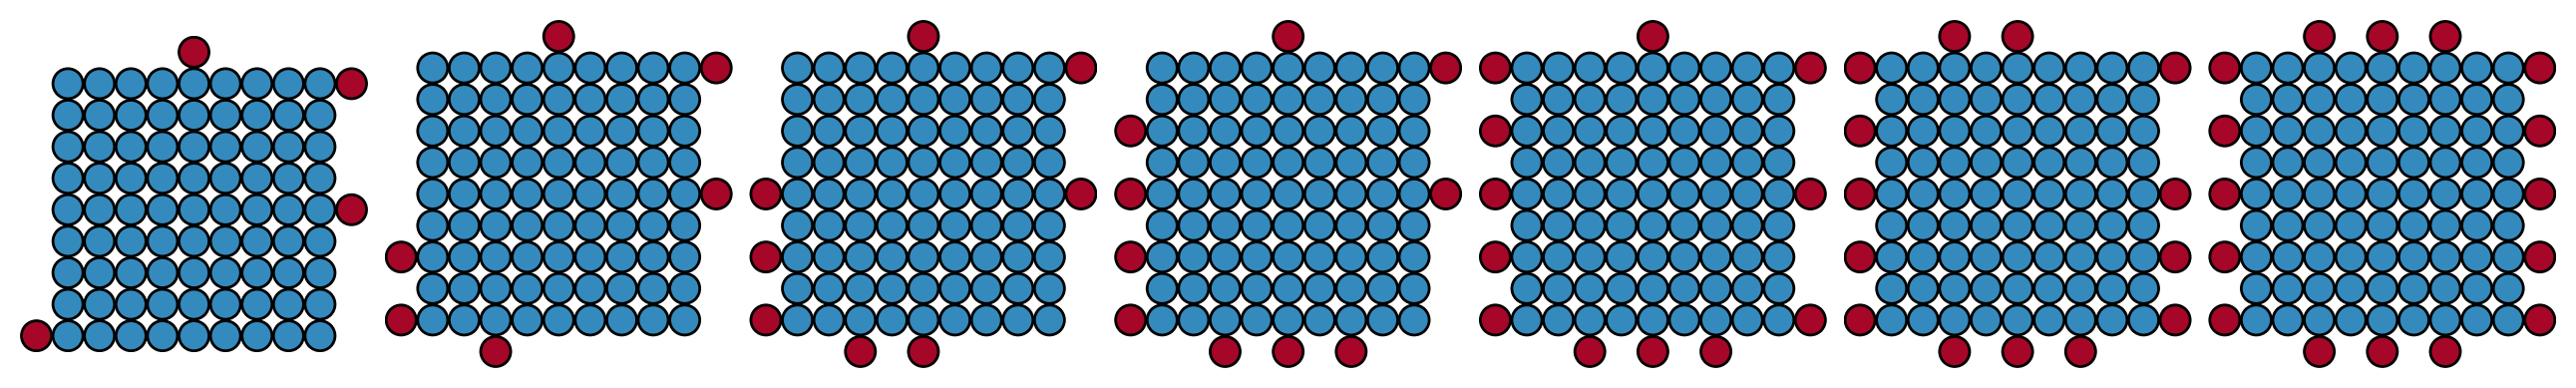

In [16]:
from nanonets import Simulation
from nanonets.utils import display_network

N_PARTICLES = 9
N_CONTROLS  = [1,3,5,7,9,11,13]

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

for i, N_c in enumerate(N_CONTROLS):
    ax   = fig.add_subplot(1,7,i+1)
    topo = {"Nx":N_PARTICLES,"Ny":N_PARTICLES}
    pos  = [[8,4],[4,8]]
    if N_c >= 1:
        pos.append([0,0])
    if N_c >= 3:
        pos.append([2,0])    
        pos.append([0,2])
    if N_c >= 5:
        pos.append([4,0])    
        pos.append([0,4])
    if N_c >= 7:
        pos.append([6,0])    
        pos.append([0,6])    
    if N_c >= 9:
        pos.append([8,0])    
        pos.append([0,8])    
    if N_c >= 11:
        pos.append([8,2])    
        pos.append([2,8])    
    if N_c >= 13:    
        pos.append([8,6])    
        pos.append([6,8])
    pos.append([8,8])
    N_e = len(pos)
    topo["e_pos"] = pos
    topo["electrode_type"] = N_e*['constant']
    sim_class = Simulation(topo, pack_optimizer=False)
    fig, ax = display_network(sim_class.get_graph(), sim_class.get_positions(), sim_class.get_radius(), fig, ax)
    ax.axis('off')
fig.savefig(f"plots/network_plots_pos_B.svg", transparent=True)

In [ ]:
# with plt.style.context(["science","bright", "grid"]):

#     for gate in GATES:
#         fig, ax = plt.subplots(dpi=200)
#         # fig.set_figwidth(fig.get_figwidth()*2.2)
#         # fig.set_figheight(fig.get_figheight()*0.8)
#         ax = sns.boxplot(fitness_res[fitness_res['Gate']==f'{gate} Fitness'], x='$N_C$', y='Fitness', hue='key', fliersize=0, ax=ax)
#         if gate[0] == 'X':
#             ax.set_ylim(-5,5)
#         else:
#             ax.set_ylim(-12,12)
#         ax.set_ylabel(f"{gate} Fitness", fontsize='large')
#         ax.set_xlabel("$N_C$", fontsize='large')
#         l = ax.legend(title='', bbox_to_anchor=(0.5,1.1), loc='center', ncol=2)
#         # l.get_texts()[0].set_text('Distant Inputs')
#         # l.get_texts()[1].set_text('Proximal Inputs')
#         fig.savefig(f"plots/{gate}_box.svg", transparent=True)

In [ ]:
# with plt.style.context(["science","bright", "grid"]):
    
#     fig = plt.figure(dpi=200, layout='constrained')
#     fig.set_figwidth(fig.get_figwidth()*2.2)
#     fig.set_figheight(fig.get_figheight()*0.8)

#     ax  = fig.add_subplot(1,3,1)
#     ax  = sns.boxplot(fitness_res[(fitness_res['Gate']=='AND Fitness') | (fitness_res['Gate']=='OR Fitness')], x='key', y='Fitness', hue='Gate', ax=ax, fliersize=0)
#     ax.set_ylim(-2,8)
#     ax.set_ylabel("Fitness")
#     ax.set_xlabel("")
#     l = ax.legend(title='', bbox_to_anchor=(0.5,1.1), loc='center', fontsize='small', ncol=2)
#     l.get_texts()[0].set_text('AND')
#     l.get_texts()[1].set_text('OR')

#     ax  = fig.add_subplot(1,3,2)
#     ax  = sns.boxplot(fitness_res[(fitness_res['Gate']=='NAND Fitness') | (fitness_res['Gate']=='NOR Fitness')], x='key', y='Fitness', hue='Gate', ax=ax, fliersize=0)
#     ax.set_ylim(-8,2)
#     ax.set_ylabel("")
#     ax.set_xlabel("")
#     l = ax.legend(title='', bbox_to_anchor=(0.5,1.1), loc='center', fontsize='small', ncol=2)
#     l.get_texts()[0].set_text('NAND')
#     l.get_texts()[1].set_text('NOR')

#     ax  = fig.add_subplot(1,3,3)
#     ax  = sns.boxplot(fitness_res[(fitness_res['Gate']=='XOR Fitness') | (fitness_res['Gate']=='XNOR Fitness')], x='key', y='Fitness', hue='Gate', ax=ax, fliersize=0)
#     ax.set_ylim(-2,2)
#     ax.set_ylabel("")
#     ax.set_xlabel("")
#     l = ax.legend(title='', bbox_to_anchor=(0.5,1.1), loc='center', fontsize='small', ncol=2)
#     l.get_texts()[0].set_text('XOR')
#     l.get_texts()[1].set_text('XNOR')

# fig.savefig("plots/box_plots.svg", transparent=True)

## Relative Error

In [8]:
# max_jumps_portionA   = [100*((dataA[N]['Jumps']==1e7).sum() / len(dataA[N])) for N in N_valsA]
# rel_error_distA      = [100*np.abs(dataA[N]['Error'].values / dataA[N]['Observable'].values) for N in N_valsA]

# max_jumps_portionB   = [100*((dataB[N]['Jumps']==1e7).sum() / len(dataB[N])) for N in N_valsB]
# rel_error_distB      = [100*np.abs(dataB[N]['Error'].values / dataB[N]['Observable'].values) for N in N_valsB]

In [9]:
# def lin_func(x, a, b):
#     return a*x + b
# def log_func(x, a, b):
#     return a * np.log(x) + b

# with plt.style.context(["science","bright","grid"]):

#     cmap    = plt.get_cmap('Reds')
#     fig     = plt.figure(dpi=200, layout='constrained')
#     ax1     = fig.add_subplot(1,2,1)
#     ax2     = fig.add_subplot(1,2,2)
#     fig.set_figwidth(fig.get_figwidth()*1.5)
#     fig.set_figheight(fig.get_figheight()*0.8)

#     for i, arr in enumerate(rel_error_distA[::-1]):
#         arr1            = arr.copy()
#         arr1[arr1 > 10] = 10
#         ax1             = sns.kdeplot(arr1, ax=ax1, color=cmap((len(rel_error_distA)-i)/len(rel_error_distA)), 
#                                       fill=True, alpha=0.1, log_scale=True)

#     ax1.set_xlim(5,12)
#     ax1.set_xlabel('$u_I / I$ [\%]')

#     x       = np.array(N_valsA)
#     y       = max_jumps_portion
#     p, _    = curve_fit(lin_func, x, y)
#     ax2.plot(x, y, 'o')
#     ax2.plot(x, lin_func(x,*p), '-')
#     ax2.set_xlabel('$N_{NP}$')
#     ax2.set_ylabel('$P[N_{j} > N_{j,max}]$ [\%]')
#     # ax2.set_xlim(0,270)

#     # fig.savefig("../plots/data_quality_vs_system_size.svg", transparent=True, bbox_inches='tight')
#     # fig.savefig("../plots/data_quality_vs_system_size.pdf", transparent=False, bbox_inches='tight')